## Part I: Global Image Matching

In [40]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.ndimage import generic_filter

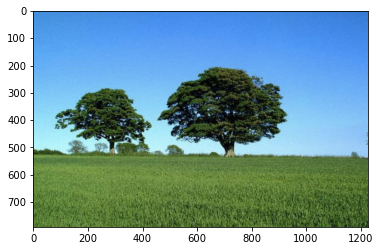

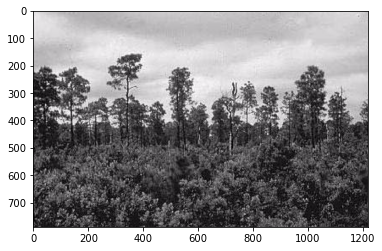

In [41]:
# reed and display the input source image and target image
global_image_1 = cv2.imread('input/global_color_4.jpg')  
global_image_2 = cv2.imread('input/global_gray_4.jpg')
plt.imshow(cv2.cvtColor(global_image_1, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(global_image_2, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
# convert images color space: BGR -> LAB
global_source = cv2.cvtColor(global_image_1, cv2.COLOR_BGR2LAB).astype("float32")
global_target = cv2.cvtColor(global_image_2, cv2.COLOR_BGR2LAB).astype("float32")

In [43]:
# luminance remapping: L = (std_t / std_s) * (1 - mu_s) + mu_t
# source_l: luminance of source
# target_l: luminance of target
def luminiance_remap(source_l, target_l):
    s_std = np.std(source_l)
    t_std = np.std(target_l)
    s_mean = np.mean(source_l)
    t_mean = np.mean(target_l)
    remap = (source_l - s_mean)* (t_std / s_std) + t_mean
    return remap

In [44]:
# luminance: source[:,:,0], a: source[:,:,1], b: source[:,:,2]
global_source[:,:,0] = luminiance_remap(global_source[:,:,0],global_target[:,:,0])

In [45]:
# jittered sampling grid: approximate 200 color sample points
# source_img: source image (LAB)
# num: number of sample points need to be generated
def jitter_sampling(source_img, num):
    n = int(np.sqrt(num)) # n * n grid size
    sample = np.zeros([n,n,3])
    height, width, _ = source_img.shape 
    y = height // n # height interval
    x = width // n # width interval
    
    for i in range(0,n):
        for j in range(0,n):
            # (0, y-1), (y, 2y-1), (2y, 3y-1)..., ((n-1)y, ny-1)
            h_start = i*y
            h_end = (i+1)*y-1
            rand_h = random.randint(h_start, h_end)
            # (0, x-1), (x, 2x-1), (2x, 3x-1)..., ((n-1)x, nx-1)
            w_start = j*x
            w_end = (j+1)*x-1
            rand_w = random.randint(w_start, w_end)
            
            sample[i,j,:] = source_img[rand_h,rand_w,:] # store sample point
            
#     print(sample)
    return sample

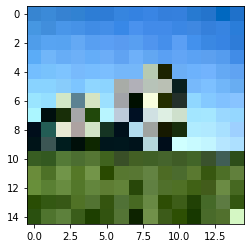

In [46]:
global_sampled_source = jitter_sampling(global_source,225)
# display the color sample points
plt.imshow(cv2.cvtColor(global_sampled_source.astype("uint8"), cv2.COLOR_LAB2RGB))
plt.show()

In [47]:
# standard deviation of the luminance in the neighborhood range
# 5*5 size neighbourhood ok
def std_neighbourhood(image, num):
    # scipy.ndimage.generic_filter(input, function, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0, extra_arguments=(), extra_keywords=None)
    std = generic_filter(image, np.std, size = num)
    return std

In [48]:
global_source_std = std_neighbourhood(global_sampled_source[:,:,0], 5)
global_target_std = std_neighbourhood(global_target[:,:,0], 5)
# print(source_std.shape)
# print(target_std.shape)

In [49]:
# Weight value: 50% luminance and 50% standard deviation
# Based on weight value, find the best matching point and assign (A,B) to target image
def color_transfer(source,target,source_std,target_std):
    # seperate lab chanel
    l_s,a_s,b_s = cv2.split(source)
    l_t,a_t,b_t = cv2.split(target)
    height, width = l_t.shape
    ratio = 0.5
    
    for i in range(height):
        for j in range(width):
            w = ratio * np.abs(l_s - l_t[i,j]) + ratio * np.abs(source_std - target_std[i,j])
            pos = np.argwhere(w == np.min(w)) # minimum w, find the closest matching point
            i_t = pos[0,0]
            j_t = pos[0,1]
            a_t[i,j] = a_s[i_t, j_t]
            b_t[i,j] = b_s[i_t, j_t]
            
    result = cv2.merge([l_t,a_t,b_t])
    result = result.astype("uint8")
    return result

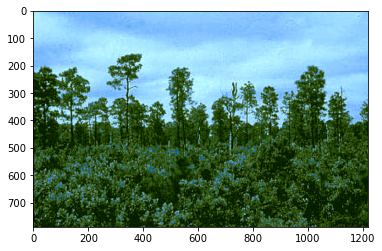

In [50]:
global_final_image = color_transfer(global_sampled_source, global_target, global_source_std, global_target_std)
global_final_image = cv2.cvtColor(global_final_image,cv2.COLOR_LAB2RGB)
plt.imshow(global_final_image)
plt.show()

In [39]:
cv2.imwrite('./output/global_output_4.jpg', cv2.cvtColor(global_final_image,cv2.COLOR_BGR2RGB))

True